In [ ]:
## trying to get scvi to work
# curl -L -O https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-MacOSX-arm64.sh
# bash Miniforge3-MacOSX-arm64.sh

# conda create -n scvi-arm python=3.12
# conda activate scvi-arm

# conda install -c conda-forge scanpy scvi-tools
# open command palette: cmd-p
# select Python interpreter: scvi-arm

In [2]:
# !pip install scanpy

In [1]:
import scanpy as sc

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
adata = sc.read_csv("../data/GSM5226574_C51ctr_raw_counts.csv.gz").T
adata

AnnData object with n_obs × n_vars = 6099 × 34546

In [3]:
# View components
# adata.obs <- dataframe of cells
# adata.var <- dataframe of genes 
# adata.X <- numpy array of counts
# adata.shape <- (cells, genes)

# Pre-processing

## Doublet removal
This step is optional but recommended because sometimes two or more cells can end up in the same droplet during scRNA-seq. \
You shouldn't do this on an integrated matrix of all samples, bur rather you do this on individual samples first and then integrate them.

In [4]:
# !pip install scvi-tools

In [5]:
import scvi

/Users/ruhi/Downloads/miniconda3/envs/scvi-arm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
adata

AnnData object with n_obs × n_vars = 6099 × 34546

In [7]:
# Only keep genes which are expressed in at least 10 cells
sc.pp.filter_genes(adata, min_cells = 10)

In [8]:
adata

AnnData object with n_obs × n_vars = 6099 × 19896
    var: 'n_cells'

In [ ]:
# !pip install scikit-misc

  Using cached scikit_misc-0.5.1-cp312-cp312-macosx_10_13_x86_64.whl.metadata (5.0 kB)
Using cached scikit_misc-0.5.1-cp312-cp312-macosx_10_13_x86_64.whl (170 kB)


In [11]:
# Only keep the top 2000 most variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True, flavor="seurat_v3")

In [12]:
adata

AnnData object with n_obs × n_vars = 6099 × 2000
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

In [13]:
# Set up an scvi model that can predict the doublets
# Note: This cell takes some time to run, especially if you don't have a GPU
scvi.model.SCVI.setup_anndata(adata)
vae = scvi.model.SCVI(adata)
vae.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/ruhi/Downloads/miniconda3/envs/scvi-arm/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|██████████| 400/400 [22:02<00:00,  1.38s/it, v_num=1, train_loss_step=319, train_loss_epoch=322]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [22:02<00:00,  3.31s/it, v_num=1, train_loss_step=319, train_loss_epoch=322]


In [14]:
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/ruhi/Downloads/miniconda3/envs/scvi-arm/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/ruhi/Downloads/miniconda3/envs/scvi-arm/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 328/400:  82%|████████▏ | 328/400 [01:28<00:19,  3.70it/s, v_num=1, train_loss_step=0.256, train_loss_epoch=0.292]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.283. Signaling Trainer to stop.


In [18]:
# Displays probabilities of being a singlet/doublet (higher --> more likely)
df = solo.predict()
# Adds a column with the predicted labels
df['prediction'] = solo.predict(soft = False)
df

/Users/ruhi/Downloads/miniconda3/envs/scvi-arm/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/Users/ruhi/Downloads/miniconda3/envs/scvi-arm/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)


,doublet,singlet,prediction
TAGGTACCATGGCCAC-1_1,0.833565,0.166435,doublet
ATTCACTGTAACAGGC-1_1,0.817652,0.182348,doublet
TAACTTCCAACCACGC-1_1,0.759934,0.240066,doublet
TTGGGTACACGACAAG-1_1,0.768899,0.231101,doublet
AGGCCACAGAGTCACG-1_1,0.753801,0.246199,doublet
...,...,...,...
CGCCATTGTTTGCCGG-1_1,0.216885,0.783115,singlet
CACTGGGGTCTACGTA-1_1,0.000541,0.999459,singlet
CATACTTGTAGAGGAA-1_1,0.009408,0.990592,singlet
TTTGGTTTCCACGGAC-1_1,0.000498,0.999502,singlet


In [19]:
# # Removes last two characters from the index (which scvi added to the barcodes)
# # Note: This was not done in my case since scvi did not add any characters to my barcodes
# df.index = df.index.map(lambda x: x[:-2])
# df

In [ ]:
df.groupby("prediction").count()
# This tells us that around 1240 cells are predicted to be doublets, which is around 20% of our dataset
# However, some of the predicted probability differences between doublets and singlets are very low,
# so we can reconsider whether we want to throw out all of the doublet-predicted cells, or make a more informed decision

,doublet,singlet
prediction,,
doublet,1243,1243
singlet,4856,4856


In [25]:
df["difference"] = df["doublet"] - df["singlet"]
df

,doublet,singlet,prediction,difference
TAGGTACCATGGCCAC-1_1,0.833565,0.166435,doublet,0.667129
ATTCACTGTAACAGGC-1_1,0.817652,0.182348,doublet,0.635303
TAACTTCCAACCACGC-1_1,0.759934,0.240066,doublet,0.519868
TTGGGTACACGACAAG-1_1,0.768899,0.231101,doublet,0.537798
AGGCCACAGAGTCACG-1_1,0.753801,0.246199,doublet,0.507603
...,...,...,...,...
CGCCATTGTTTGCCGG-1_1,0.216885,0.783115,singlet,-0.566230
CACTGGGGTCTACGTA-1_1,0.000541,0.999459,singlet,-0.998918
CATACTTGTAGAGGAA-1_1,0.009408,0.990592,singlet,-0.981183
TTTGGTTTCCACGGAC-1_1,0.000498,0.999502,singlet,-0.999004


In [22]:
import seaborn as sns

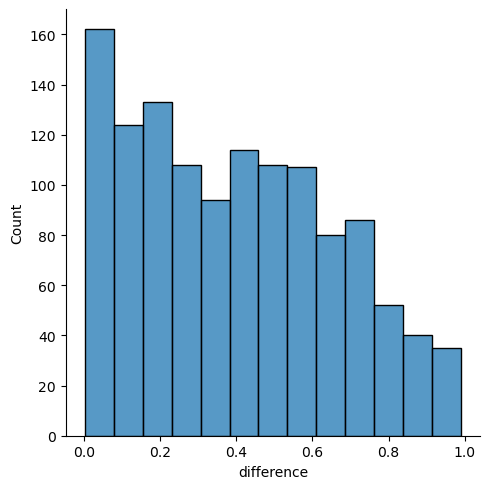

In [28]:
sns.displot(df[df.prediction == 'doublet'], x = 'difference')

In [ ]:
# A difference above 0.1 was chosen arbitrarily based on the sns distribution
doublets = df[(df.prediction == 'doublet') & (df.difference > 0.1)]
doublets

,doublet,singlet,prediction,difference
TAGGTACCATGGCCAC-1_1,0.833565,0.166435,doublet,0.667129
ATTCACTGTAACAGGC-1_1,0.817652,0.182348,doublet,0.635303
TAACTTCCAACCACGC-1_1,0.759934,0.240066,doublet,0.519868
TTGGGTACACGACAAG-1_1,0.768899,0.231101,doublet,0.537798
AGGCCACAGAGTCACG-1_1,0.753801,0.246199,doublet,0.507603
...,...,...,...,...
ACCTGAAGTGGCTGAA-1_1,0.567181,0.432819,doublet,0.134361
GGAGGTAGTTAAGCAA-1_1,0.610602,0.389398,doublet,0.221203
CGGGCATCATGGCTGC-1_1,0.633712,0.366288,doublet,0.267424
GACTCAAGTTGTCCCT-1_1,0.637190,0.362810,doublet,0.274379


In [32]:
adata

AnnData object with n_obs × n_vars = 6099 × 2000
    obs: '_scvi_batch', '_scvi_labels'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid'

In [33]:
adata = sc.read_csv("../data/GSM5226574_C51ctr_raw_counts.csv.gz").T
adata

AnnData object with n_obs × n_vars = 6099 × 34546

In [37]:
adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
adata.obs

,doublet
TAGGTACCATGGCCAC-1_1,True
ATTCACTGTAACAGGC-1_1,True
TAACTTCCAACCACGC-1_1,True
TTGGGTACACGACAAG-1_1,True
AGGCCACAGAGTCACG-1_1,True
...,...
CGCCATTGTTTGCCGG-1_1,False
CACTGGGGTCTACGTA-1_1,False
CATACTTGTAGAGGAA-1_1,False
TTTGGTTTCCACGGAC-1_1,False


In [38]:
adata = adata[~adata.obs.doublet]
# The tilde means False i.e. this keeps all cells that are not doublets
adata

View of AnnData object with n_obs × n_vars = 5058 × 34546
    obs: 'doublet'